<a href="https://colab.research.google.com/github/svitery/proyecto_3_intro_ciencia_de_datos/blob/main/Proyecto3_Ciencia_de_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del costo de un proyecto de software basado en las características del equipo

Se busca estimar las horas que puede tomar un proyecto de software basado en la complejidad de la solución y en las características del equipo.

## Funciones útiles

In [1]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [52]:
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
import sklearn.ensemble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Procesamiento de datos

Software cost estimation from PROMISE

In [3]:
df = pd.read_csv('fp.csv')

In [4]:
df.head()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language
0,1,1,1,4,85,12,5152,253,52,305,34,302,1
1,2,2,0,0,86,4,5635,197,124,321,33,315,1
2,3,3,4,4,85,1,805,40,60,100,18,83,1
3,4,4,0,0,86,5,3829,200,119,319,30,303,1
4,5,5,0,0,86,4,2149,140,94,234,24,208,1


In [5]:
x = df[['TeamExp','ManagerExp','Transactions','Entities',]]
y = df[['Effort']]

In [6]:
x.head()

,TeamExp,ManagerExp,Transactions,Entities
0,1,4,253,52
1,0,0,197,124
2,4,4,40,60
3,0,0,200,119
4,0,0,140,94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


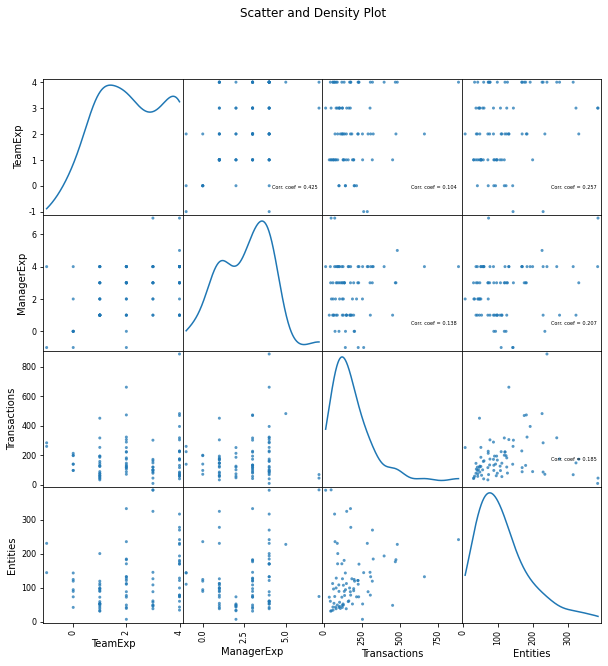

In [7]:
plotScatterMatrix(x, 10, 5)

In [8]:
predictors = list(x.keys())
predictors

['TeamExp', 'ManagerExp', 'Transactions', 'Entities']

In [13]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x[predictors], y, test_size=0.3)
y_test=np.ravel(y_test)
y_train=np.ravel(y_train)

## Regresión lineal

In [53]:
reg = LinearRegression().fit(x_train, y_train)

In [54]:
predictions=reg.predict(x_test)

In [55]:
sklearn.metrics.r2_score(y_test, predictions)

0.3506222609203514

## Bosques aleatorios

In [10]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=200)

In [14]:
rf.fit(x_train,y_train)

RandomForestRegressor(n_estimators=200)

In [15]:
y_pred = rf.predict(x_test)

In [16]:
sklearn.metrics.r2_score(y_test, y_pred)

0.3546820467539137

In [29]:
n_trees = np.arange(1,300,1)
r2_train = []
r2_test = []

feature_importance=np.zeros((len(n_trees),len(predictors)))

for i, n_tree in enumerate(n_trees):
  rf = sklearn.ensemble.RandomForestRegressor(n_estimators=n_tree)
  rf.fit(x_train, y_train)

  r2_train.append(sklearn.metrics.r2_score(y_train, rf.predict(x_train)))
  r2_test.append(sklearn.metrics.r2_score(y_test, rf.predict(x_test)))

  feature_importance[i,:]=rf.feature_importances_

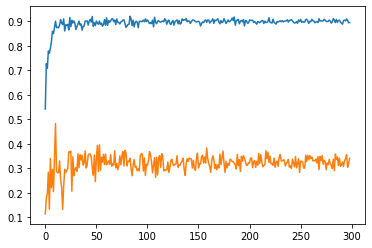

In [30]:
plt.plot(r2_train)
plt.plot(r2_test)

plt.show()

In [31]:
best_r2_score=max(r2_test)
index=r2_test.index(best_r2_score)
best_n_trees=n_trees[index]
print(f'Se obtuvo el mejor resultado para {best_n_trees} árboles con un r2 score de {best_r2_score}')

Se obtuvo el mejor resultado para 11 árboles con un r2 score de 0.48297389114031997


Text(0.5, 0, 'Avg feature importance')

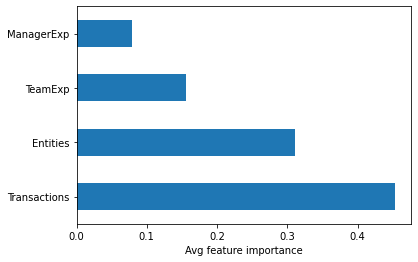

In [33]:
avg_importances=np.average(feature_importance,axis=0)
a = pd.Series(avg_importances,index=predictors)
a.nlargest().plot(kind='barh')
plt.xlabel('Avg feature importance')

## Conclusión

Aunque se presenta una relación lineal entre los cuatro predictores y el tiempo empleado en los proyectos, la relación no es suficientemente fuerte como para implementar este sistema en la práctica. Este desempeño puede estar asociado a la cantidad de datos del dataset.